In [10]:
!pip install simpy

Pacjent 1  przyszedł do przychodni o 08:01 (priorytet: 2).
Pacjent 1  zaczyna wizytę o 08:01. Czas oczekiwania: 0.00 minut.
Pacjent 2  przyszedł do przychodni o 08:01 (priorytet: 2).
Pacjent 2  zaczyna wizytę o 08:01. Czas oczekiwania: 0.00 minut.
Pacjent 3  przyszedł do przychodni o 08:05 (priorytet: 2).
Pacjent 3  zaczyna wizytę o 08:05. Czas oczekiwania: 0.00 minut.
Pacjent 4 (priorytet) przyszedł do przychodni o 08:11 (priorytet: 1).
Pacjent 5  przyszedł do przychodni o 08:12 (priorytet: 2).
Pacjent 1  skończył wizytę o 08:15.
Pacjent 4 (priorytet) zaczyna wizytę o 08:15. Czas oczekiwania: 4.00 minut.
Pacjent 6  przyszedł do przychodni o 08:19 (priorytet: 2).
Pacjent 7 (priorytet) przyszedł do przychodni o 08:19 (priorytet: 1).
Pacjent 4 (priorytet) skończył wizytę o 08:25.
Pacjent 7 (priorytet) zaczyna wizytę o 08:25. Czas oczekiwania: 5.14 minut.
Pacjent 8  przyszedł do przychodni o 08:25 (priorytet: 2).
Pacjent 7 (priorytet) skończył wizytę o 08:27.
Pacjent 5  zaczyna wizytę o 0

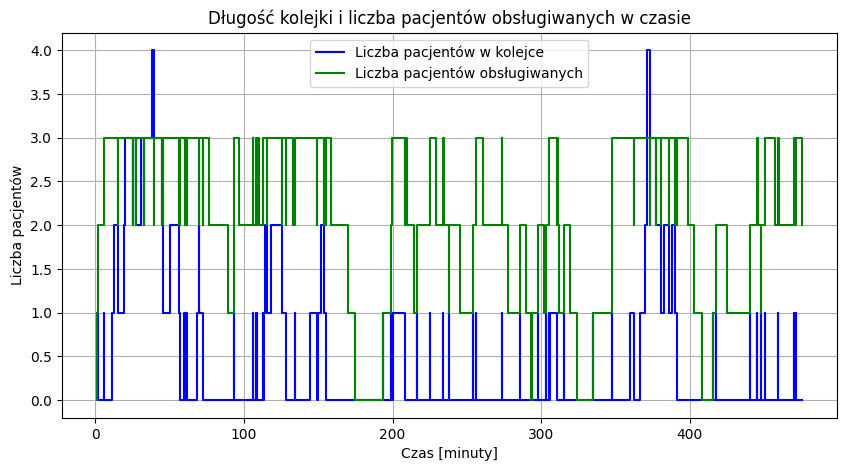

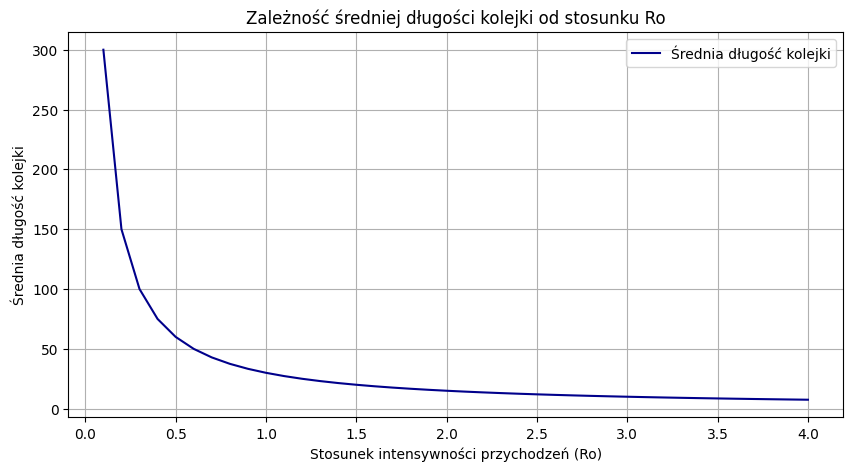

In [11]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Parametry symulacji
LAMBDA = 6  # średnia liczba pacjentów na godzinę (przychodzą zgodnie z procesem Poissona)
MU = 1 / 15  # średni czas wizyty wynosi 15 minut (rozkład wykładniczy)
SIM_TIME = 8 * 60  # symulacja 8 godzin (w minutach)
LEKARZE = 3  # liczba lekarzy (kanałów)

total_patients = 0
waiting_times = []

time_data = []
queue_data = []
in_service_data = []

def format_time(minuty):
    godzina = int(minuty // 60 + 8)
    minuta = int(minuty % 60)
    return f"{godzina:02}:{minuta:02}"

class Przychodnia:
    def __init__(self, env, liczba_lekarzy):
        self.env = env
        self.lekarz = simpy.PriorityResource(env, capacity=liczba_lekarzy)
        self.patients_in_queue = 0
        self.patients_in_service = 0

    def wizyta(self, pacjent):
        """Symulacja wizyty pacjenta, która trwa losowo zgodnie z rozkładem wykładniczym"""
        self.patients_in_service += 1
        update_data(self.env.now, self.patients_in_queue, self.patients_in_service)

        czas_wizyty = random.expovariate(MU)
        yield self.env.timeout(czas_wizyty)

        self.patients_in_service -= 1
        update_data(self.env.now, self.patients_in_queue, self.patients_in_service)
        print(f"{pacjent['name']} skończył wizytę o {format_time(self.env.now)}.")

def pacjent(env, name, przychodnia, priorytet):
    """Funkcja dla pacjenta, który przychodzi do lekarza"""
    global total_patients
    arrival_time = env.now
    print(f"{name} przyszedł do przychodni o {format_time(arrival_time)} (priorytet: {priorytet}).")

    przychodnia.patients_in_queue += 1
    update_data(env.now, przychodnia.patients_in_queue, przychodnia.patients_in_service)

    with przychodnia.lekarz.request(priority=priorytet) as request:
        yield request
        przychodnia.patients_in_queue -= 1
        waiting_time = env.now - arrival_time
        waiting_times.append(waiting_time)

        print(f"{name} zaczyna wizytę o {format_time(env.now)}. Czas oczekiwania: {waiting_time:.2f} minut.")

        yield env.process(przychodnia.wizyta({'name': name}))
        total_patients += 1

def proces_nadejscia(env, przychodnia):
    """Generowanie pacjentów zgodnie z procesem Poissona"""
    i = 0
    while True:
        czas_nastepnego = random.expovariate(LAMBDA / 60)  # czas między pacjentami (w minutach)
        yield env.timeout(czas_nastepnego)
        i += 1

        # Wybieramy losowy priorytet (1 - wyższy priorytet, 2 - niższy priorytet)
        # priorytet = random.choice([1, 2])
        # Ciekawsze priorytety 1 - 30%, 2 - 70%
        priorytet = random.choices([1, 2], weights=[0.3, 0.7])[0] 
        name = f"Pacjent {i} {'(priorytet)' if priorytet == 1 else ''}"

        env.process(pacjent(env, name, przychodnia, priorytet))

def update_data(time, patients_in_queue, patients_in_service):
    """Funkcja do aktualizacji danych do wykresów"""
    time_data.append(time)
    queue_data.append(patients_in_queue)
    in_service_data.append(patients_in_service)

def run_simulation():
    global total_patients, waiting_times
    env = simpy.Environment()
    przychodnia = Przychodnia(env, LEKARZE)

    env.process(proces_nadejscia(env, przychodnia))

    env.run(until=SIM_TIME)

    print("\nSymulacja zakończona.")
    print(f"Liczba obsłużonych pacjentów: {total_patients}")
    if waiting_times:
        print(f"Średni czas oczekiwania: {np.mean(waiting_times):.2f} minut")
    else:
        print("Nie było żadnych pacjentów w kolejce.")

# Uruchomienie symulacji
if __name__ == "__main__":
    run_simulation()

    # Wykres 1: Liczba pacjentów w kolejce i obsługiwanych
    plt.figure(figsize=(10, 5))
    plt.step(time_data, queue_data, label='Liczba pacjentów w kolejce', color='blue', where='post')
    plt.step(time_data, in_service_data, label='Liczba pacjentów obsługiwanych', color='green', where='post')
    plt.xlabel("Czas [minuty]")
    plt.ylabel("Liczba pacjentów")
    plt.title("Długość kolejki i liczba pacjentów obsługiwanych w czasie")
    plt.legend()
    plt.grid()
    plt.show()

    # Wykres 2: Średnia długość kolejki w zależności od intensywności (Ro)
    ro_values = np.linspace(0.1, 4.0, 40)
    avg_queue_lengths = []

    for ro in ro_values:
        # Przy obciążeniu Ro, liczba pacjentów oczekujących
        avg_queue_length = LAMBDA / (LEKARZE * MU * ro)
        avg_queue_lengths.append(avg_queue_length)

    plt.figure(figsize=(10, 5))
    plt.plot(ro_values, avg_queue_lengths, label='Średnia długość kolejki', color='darkblue')
    plt.xlabel("Stosunek intensywności przychodzeń (Ro)")
    plt.ylabel("Średnia długość kolejki")
    plt.title("Zależność średniej długości kolejki od stosunku Ro")
    plt.legend()
    plt.grid()
    plt.show()


Pacjent 1 (Priorytet 2) przyszedł do przychodni o 08:00 (priorytet: 2).
Pacjent 1 (Priorytet 2) zaczyna wizytę u lekarza 3 o 08:00. Czas oczekiwania: 0.00 minut.
Pacjent 2 (Priorytet 3) przyszedł do przychodni o 08:06 (priorytet: 3).
Pacjent 2 (Priorytet 3) zaczyna wizytę u lekarza 2 o 08:06. Czas oczekiwania: 0.00 minut.
Pacjent 3 (Priorytet 3) przyszedł do przychodni o 08:12 (priorytet: 3).
Pacjent 3 (Priorytet 3) zaczyna wizytę u lekarza 1 o 08:12. Czas oczekiwania: 0.00 minut.
Pacjent 4 (Priorytet 3) przyszedł do przychodni o 08:17 (priorytet: 3).
Pacjent 5 (Priorytet 3) przyszedł do przychodni o 08:20 (priorytet: 3).
Pacjent 6 (Priorytet 3) przyszedł do przychodni o 08:29 (priorytet: 3).
Pacjent 1 (Priorytet 2) skończył wizytę o 08:30.
Pacjent 4 (Priorytet 3) zaczyna wizytę u lekarza 3 o 08:30. Czas oczekiwania: 13.93 minut.
Pacjent 2 (Priorytet 3) skończył wizytę o 08:31.
Pacjent 5 (Priorytet 3) zaczyna wizytę u lekarza 1 o 08:31. Czas oczekiwania: 10.66 minut.
Pacjent 7 (Prioryt

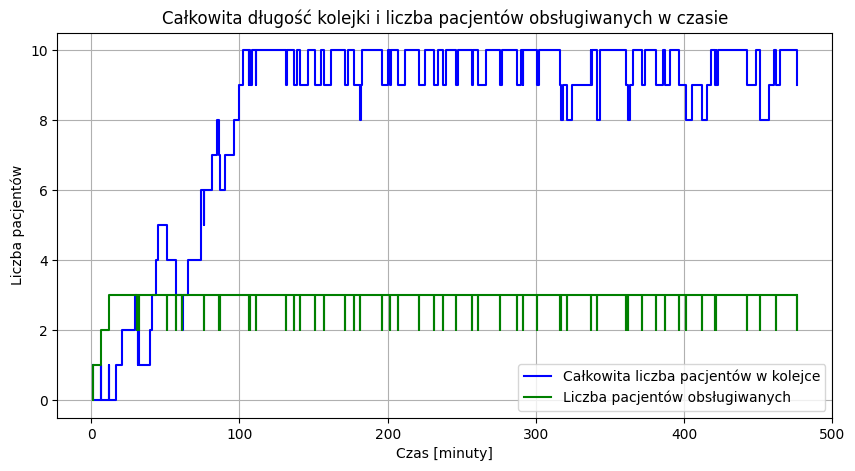

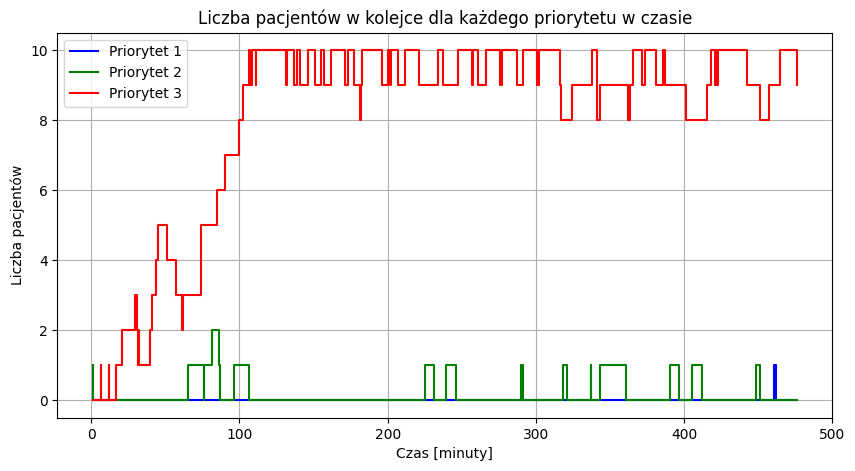

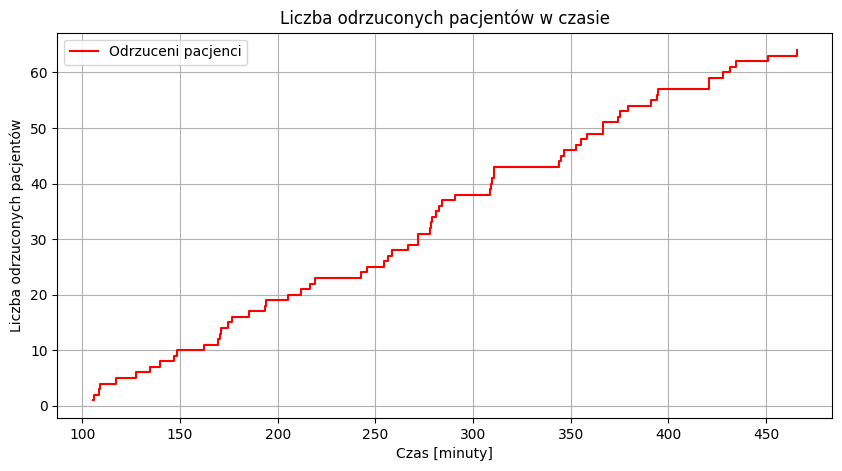

In [ ]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

waiting_times_priority_1 = []
waiting_times_priority_2 = []
waiting_times_priority_3 = []

# Parametry symulacji
LAMBDA = 15  # średnia liczba pacjentów na godzinę (przychodzą zgodnie z procesem Poissona)
SIM_TIME = 8 * 60  # symulacja 8 godzin (w minutach)
LEKARZE = 3  # liczba lekarzy (kanałów)
MAX_QUEUE_SIZE = 10  # maksymalna pojemność kolejki

# Ustawienia czasów wizyt dla poszczególnych lekarzy (w minutach)
CZASY_WIZYT_LEKARZY = [10, 15, 20]

total_patients = 0
waiting_times = []
rejected_patients = 0

time_data = []
queue_data_priority_1 = []
queue_data_priority_2 = []
queue_data_priority_3 = []
total_queue_data = []
in_service_data = []
rejected_data = []

def format_time(minuty):
    godzina = int(minuty // 60 + 8)
    minuta = int(minuty % 60)
    return f"{godzina:02}:{minuta:02}"

class Przychodnia:
    def __init__(self, env, liczba_lekarzy, czasy_wizyt):
        self.env = env
        self.lekarz = simpy.PriorityResource(env, capacity=liczba_lekarzy)
        self.patients_in_queue = {1: 0, 2: 0, 3: 0}
        self.patients_in_service = 0
        self.czasy_wizyt = czasy_wizyt

    def wizyta(self, pacjent, lekarz_index):
        """Symulacja wizyty pacjenta z różnym czasem trwania dla każdego lekarza"""
        self.patients_in_service += 1
        update_data(self.env.now, self.patients_in_queue, self.patients_in_service) 

        czas_wizyty = self.czasy_wizyt[lekarz_index]
        yield self.env.timeout(czas_wizyty)

        self.patients_in_service -= 1
        update_data(self.env.now, self.patients_in_queue, self.patients_in_service)
        print(f"{pacjent['name']} skończył wizytę o {format_time(self.env.now)}.")

def pacjent(env, name, przychodnia, priorytet):
    global total_patients, rejected_patients
    arrival_time = env.now

    if sum(przychodnia.patients_in_queue.values()) >= MAX_QUEUE_SIZE:
        print(f"{name} został odrzucony o {format_time(arrival_time)} z powodu pełnej kolejki.")
        rejected_patients += 1
        rejected_data.append((env.now, rejected_patients))
        return

    print(f"{name} przyszedł do przychodni o {format_time(arrival_time)} (priorytet: {priorytet}).")
    przychodnia.patients_in_queue[priorytet] += 1
    update_data(env.now, przychodnia.patients_in_queue, przychodnia.patients_in_service)

    with przychodnia.lekarz.request(priority=priorytet) as request:
        yield request
        przychodnia.patients_in_queue[priorytet] -= 1
        waiting_time = env.now - arrival_time
        waiting_times.append(waiting_time)

        if priorytet == 1:
            waiting_times_priority_1.append(waiting_time)
        elif priorytet == 2:
            waiting_times_priority_2.append(waiting_time)
        else:
            waiting_times_priority_3.append(waiting_time)

        lekarz_index = random.randint(0, len(przychodnia.czasy_wizyt) - 1)
        print(f"{name} zaczyna wizytę u lekarza {lekarz_index + 1} o {format_time(env.now)}. Czas oczekiwania: {waiting_time:.2f} minut.")

        yield env.process(przychodnia.wizyta({'name': name}, lekarz_index))
        total_patients += 1

def proces_nadejscia(env, przychodnia):
    """Generowanie pacjentów zgodnie z procesem Poissona"""
    i = 0
    while True:
        czas_nastepnego = random.expovariate(LAMBDA / 60)
        yield env.timeout(czas_nastepnego)
        i += 1

        priorytet = random.choices([1, 2, 3], weights=[0.1, 0.2, 0.7])[0]
        name = f"Pacjent {i} (Priorytet {priorytet})"

        env.process(pacjent(env, name, przychodnia, priorytet))

def update_data(time, patients_in_queue, patients_in_service):
    """Funkcja do aktualizacji danych do wykresów"""
    time_data.append(time)
    queue_data_priority_1.append(patients_in_queue[1])
    queue_data_priority_2.append(patients_in_queue[2])
    queue_data_priority_3.append(patients_in_queue[3])
    total_queue_data.append(sum(patients_in_queue.values()))
    in_service_data.append(patients_in_service)

def run_simulation():
    global total_patients, waiting_times, rejected_patients
    env = simpy.Environment()
    przychodnia = Przychodnia(env, LEKARZE, CZASY_WIZYT_LEKARZY)

    env.process(proces_nadejscia(env, przychodnia))

    env.run(until=SIM_TIME)

    print("\nSymulacja zakończona.")
    print(f"Liczba obsłużonych pacjentów: {total_patients}")
    print(f"Liczba odrzuconych pacjentów: {rejected_patients}")
    if waiting_times:
        print(f"Średni czas oczekiwania: {np.mean(waiting_times):.2f} minut")
    else:
        print("Nie było żadnych pacjentów w kolejce.")

if __name__ == "__main__":
    run_simulation()

    # Wykres 1: Całkowita liczba pacjentów w kolejce i liczba pacjentów obsługiwanych
    plt.figure(figsize=(10, 5))
    plt.step(time_data, total_queue_data, label='Całkowita liczba pacjentów w kolejce', color='blue', where='post')
    plt.step(time_data, in_service_data, label='Liczba pacjentów obsługiwanych', color='green', where='post')
    plt.xlabel("Czas [minuty]")
    plt.ylabel("Liczba pacjentów")
    plt.title("Całkowita długość kolejki i liczba pacjentów obsługiwanych w czasie")
    plt.legend()
    plt.grid()
    plt.show()

    # Wykres 2: Liczba pacjentów w kolejce dla każdego priorytetu
    plt.figure(figsize=(10, 5))
    plt.step(time_data, queue_data_priority_1, label='Priorytet 1', color='blue', where='post')
    plt.step(time_data, queue_data_priority_2, label='Priorytet 2', color='green', where='post')
    plt.step(time_data, queue_data_priority_3, label='Priorytet 3', color='red', where='post')
    plt.xlabel("Czas [minuty]")
    plt.ylabel("Liczba pacjentów")
    plt.title("Liczba pacjentów w kolejce dla każdego priorytetu w czasie")
    plt.legend()
    plt.grid()
    plt.show()


    # Wykres 3: Liczba odrzuconych pacjentów w czasie
    rejected_times, rejected_counts = zip(*rejected_data) if rejected_data else ([], [])
    plt.figure(figsize=(10, 5))
    plt.step(rejected_times, rejected_counts, label='Odrzuceni pacjenci', color='red', where='post')
    plt.xlabel("Czas [minuty]")
    plt.ylabel("Liczba odrzuconych pacjentów")
    plt.title("Liczba odrzuconych pacjentów w czasie")
    plt.legend()
    plt.grid()
    plt.show()
